# 11.8. RMSProp算法
11.7节中的关键问题之一，是学习率按预定时间表$\mathcal{O}(t^{-\frac{1}{2}})$显著降低。虽然这通常适用于凸问题，但对于深度学习中遇到的非凸问题，可能并不理想。但是，作为一个预处理器，Adagrad算法按坐标顺序的适应性是非常可取的。

`Tieleman.Hinton.2012`建议以RMSProp算法作为将速率调度与坐标自适应学习率分离的简单修复方法。问题在于，Adagrad算法将梯度$\mathbf{g}_t$的平方累加成状态矢量$\mathbf{s}_t = \mathbf{s}_{t-1} + \mathbf{g}_t^2$。因此，由于缺乏规范化，没有约束力，$\mathbf{s}_t$持续增长，几乎上是在算法收敛时呈线性递增。

解决此问题的一种方法是使用$\mathbf{s}_t / t$。对于$\mathbf{g}_t$的合理分布来说，它将收敛。遗憾的是，限制行为生效可能需要很长时间，因为该流程记住了值的完整轨迹。另一种方法是按动量法中的方式使用泄漏平均值，即$\mathbf{s}_t \leftarrow \gamma \mathbf{s}_{t-1} + (1-\gamma) \mathbf{g}_t^2$，其中参数$\gamma > 0$。保持所有其它部分不变就产生了RMSProp算法。

## 11.8.1. 算法

让我们详细写出这些方程式。

$$\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}
\tag{11.8.1}
$$

常数$\epsilon > 0$通常设置为$10^{-6}$，以确保我们不会因除以零或步长过大而受到影响。鉴于这种扩展，我们现在可以自由控制学习率$\eta$，而不考虑基于每个坐标应用的缩放。就泄漏平均值而言，我们可以采用与之前在动量法中适用的相同推理。扩展$\mathbf{s}_t$定义可获得

$$
\begin{aligned}
\mathbf{s}_t & = (1 - \gamma) \mathbf{g}_t^2 + \gamma \mathbf{s}_{t-1} \\
& = (1 - \gamma) \left(\mathbf{g}_t^2 + \gamma \mathbf{g}_{t-1}^2 + \gamma^2 \mathbf{g}_{t-2} + \ldots, \right).
\end{aligned}
\tag{11.8.2}
$$

同之前在11.6小节一样，我们使用$1 + \gamma + \gamma^2 + \ldots, = \frac{1}{1-\gamma}$。因此，权重总和标准化为$1$且观测值的半衰期为$\gamma^{-1}$。让我们图像化各种数值的$\gamma$在过去40个时间步长的权重。

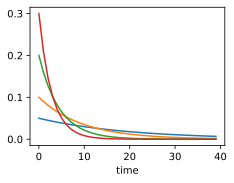

In [1]:
import math
import torch
from d2l import torch as d2l

d2l.set_figsize()
gammas = [0.95, 0.9, 0.8, 0.7]
for gamma in gammas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, (1-gamma) * gamma ** x, label=f'gamma = {gamma:.2f}')
d2l.plt.xlabel('time');

## 11.8.2. 从零开始实现
和之前一样，我们使用二次函数$f(\mathbf{x})=0.1x_1^2+2x_2^2$来观察RMSProp算法的轨迹。回想在11.7一节中，当我们使用学习率为0.4的Adagrad算法时，变量在算法的后期阶段移动非常缓慢，因为学习率衰减太快。RMSProp算法中不会发生这种情况，因为$\eta$是单独控制的。

epoch 20, x1: -0.010599, x2: 0.000000


/home/zhang/anaconda3/envs/d2l/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352463056/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


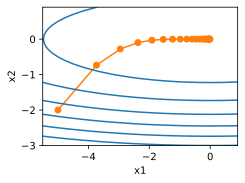

In [2]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

In [4]:
"""
接下来，我们在深度网络中实现RMSProp算法。
"""
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

我们将初始学习率设置为0.01，加权项$\gamma$设置为0.9。也就是说，$\mathbf{s}$累加了过去的$1/(1-\gamma) = 10$次平方梯度观测值的平均值。

In [5]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

loss: 0.243, 0.004 sec/epoch


## 11.8.3. 简洁实现

In [7]:
"""
我们可直接使用深度学习框架中提供的RMSProp算法来训练模型。
"""
trainer = torch.optim.RMSprop
d2l.train_concise_ch11(trainer, {'lr': 0.01, 'alpha': 0.9},
                       data_iter)

loss: 0.245, 0.003 sec/epoch


## 11.8.4. 小结
* RMSProp算法与Adagrad算法非常相似，因为两者都使用梯度的平方来缩放系数。
* RMSProp算法与动量法都使用泄漏平均值。但是，RMSProp算法使用该技术来调整按系数顺序的预处理器。
* 在实验中，学习率需要由实验者调度。
* 系数$\gamma$决定了在调整每坐标比例时历史记录的时长。